# pip installs

In [62]:
!pip install datasets


# imports


In [63]:
#title
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import re
import string


# EDA 1

In [64]:
#loading data
dataset = load_dataset("artem9k/ai-text-detection-pile")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'text'],
        num_rows: 1392522
    })
})


In [65]:

data = dataset["train"].to_pandas()
data.head()

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...


In [66]:
#null
print(data.isnull().sum())

source    0
id        0
text      0
dtype: int64


source
human    1028146
ai        364376
Name: count, dtype: int64


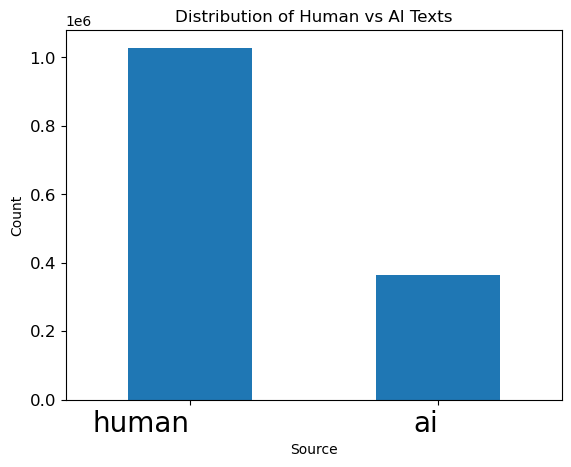

In [94]:
print(data["source"].value_counts())
data["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

# data engineering 1

In [68]:
#balancing data to 300,000 rows each

human_df = data[data["source"] == "human"].sample(n=300000, random_state=42)
ai_df    = data[data["source"] == "ai"].sample(n=300000, random_state=42)


df = pd.concat([human_df, ai_df]).reset_index(drop=True)

print(df["source"].value_counts())

source
human    300000
ai       300000
Name: count, dtype: int64


# EDA 2

In [69]:
#text length mean 

df["text_length"] = df["text"].str.len()

print("text length by source: ",df.groupby("source")["text_length"].mean())

text length by source:  source
ai       2219.645987
human    2459.212590
Name: text_length, dtype: float64


In [70]:
print("text length by source: ",df.groupby("source")["text_length"].median())

text length by source:  source
ai       1771.0
human     996.0
Name: text_length, dtype: float64


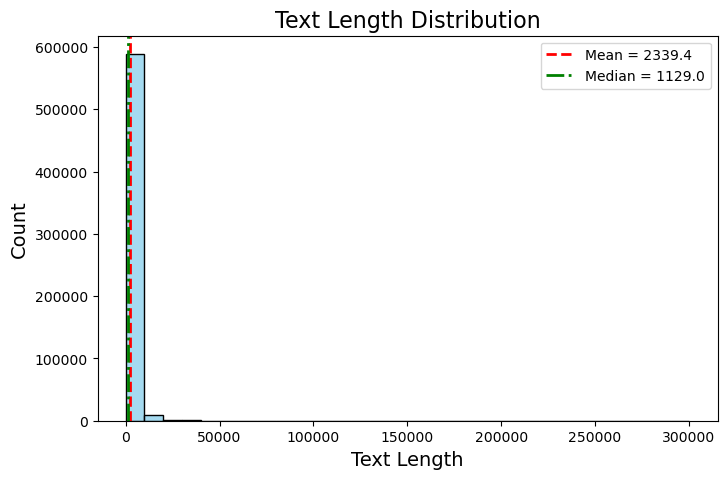

In [98]:


plt.figure(figsize=(8,5))

# Plot a single histogram (no separation by source)
sns.histplot(df["text_length"], bins=30, kde=False, color="skyblue")

# Calculate stats
mean_val = df["text_length"].mean()
median_val = df["text_length"].median()

# Add lines
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.1f}")

# Titles & labels
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

plt.show()


In [72]:
# counting sentences

def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split by ., !, ? followed by space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    # Remove empty strings
    sentences = [s for s in sentences if s]
    return len(sentences)

df["sentence_count"] = df["text"].apply(count_sentences)

In [73]:
print(df.groupby("source")["sentence_count"].mean())       # average sentences


source
ai       17.901023
human    24.918143
Name: sentence_count, dtype: float64


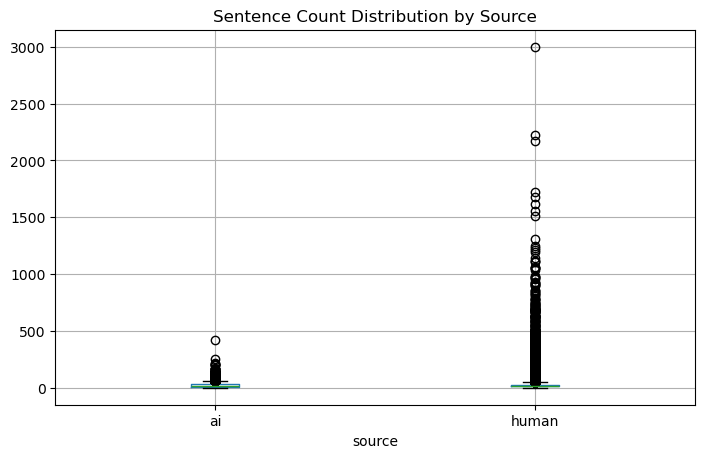

In [74]:
df.boxplot(column="sentence_count", by="source", figsize=(8,5))
plt.title("Sentence Count Distribution by Source")
plt.suptitle("")
plt.show()

In [75]:
def count_words(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(text.split())

def avg_words_per_sentence(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split into sentences
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    sentences = [s for s in sentences if s.strip()]
    if not sentences:
        return 0
    # Count words in each sentence
    word_counts = [len(s.split()) for s in sentences]
    return sum(word_counts) / len(word_counts)

df["word_count"] = df["text"].apply(count_words)
df["avg_words_per_sentence"] = df["text"].apply(avg_words_per_sentence)


        word_count  avg_words_per_sentence
source                                    
ai      386.738653               23.392167
human   405.393557               17.584612


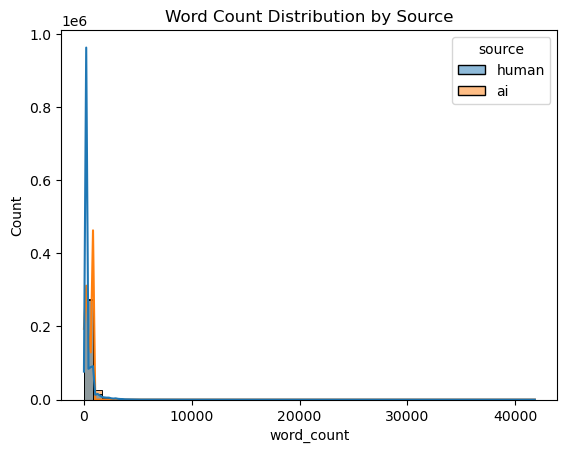

In [76]:
print(df.groupby("source")[["word_count", "avg_words_per_sentence"]].mean())
sns.histplot(data=df, x="word_count", hue="source", kde=True, bins=50)
plt.title("Word Count Distribution by Source")
plt.show()

In [77]:
punctuations = string.punctuation  # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# Count occurrences of each punctuation in every text
for p in punctuations:
    df[f"count_{p}"] = df["text"].str.count(re.escape(p))

In [78]:
punct_summary = df.groupby("source")[[col for col in df.columns if col.startswith("count_")]].sum().T
punct_summary.columns = ["AI", "Human"] if "ai" in punct_summary.columns else punct_summary.columns
print(punct_summary)

              AI    Human
count_!    96275   188951
count_"  2049144   520298
count_#    21826    23569
count_$   117155    65084
count_%    47173    69619
count_&    24074   139361
count_'  2262153  2079827
count_(   410936   789862
count_)   425297   793721
count_*    19702   284795
count_+    20048    24778
count_,  5546386  6518631
count_-  1117269  1209751
count_.  5896752  7956139
count_/   193551   181592
count_:   449305   487578
count_;    84820   151519
count_<    14818     9956
count_=    36690    45153
count_>    22284    21959
count_?   206910   341368
count_@    18400    13171
count_[    68904    43493
count_\     4636     4239
count_]    67547    43729
count_^      800     6601
count__    61784   105077
count_`     1558   845413
count_{     8643     7412
count_|    13480     9867
count_}     8302     7101
count_~     3603     8391


In [79]:
punct_avg = df.groupby("source")[[col for col in df.columns if col.startswith("count_")]].mean().T
print(punct_avg)

source          ai      human
count_!   0.320917   0.629837
count_"   6.830480   1.734327
count_#   0.072753   0.078563
count_$   0.390517   0.216947
count_%   0.157243   0.232063
count_&   0.080247   0.464537
count_'   7.540510   6.932757
count_(   1.369787   2.632873
count_)   1.417657   2.645737
count_*   0.065673   0.949317
count_+   0.066827   0.082593
count_,  18.487953  21.728770
count_-   3.724230   4.032503
count_.  19.655840  26.520463
count_/   0.645170   0.605307
count_:   1.497683   1.625260
count_;   0.282733   0.505063
count_<   0.049393   0.033187
count_=   0.122300   0.150510
count_>   0.074280   0.073197
count_?   0.689700   1.137893
count_@   0.061333   0.043903
count_[   0.229680   0.144977
count_\   0.015453   0.014130
count_]   0.225157   0.145763
count_^   0.002667   0.022003
count__   0.205947   0.350257
count_`   0.005193   2.818043
count_{   0.028810   0.024707
count_|   0.044933   0.032890
count_}   0.027673   0.023670
count_~   0.012010   0.027970


In [80]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_[,count_\,count_],count_^,count__,count_`,count_{,count_|,count_},count_~
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,0,0,14,0,0,0,0
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,0,0,6,0,0,0,0


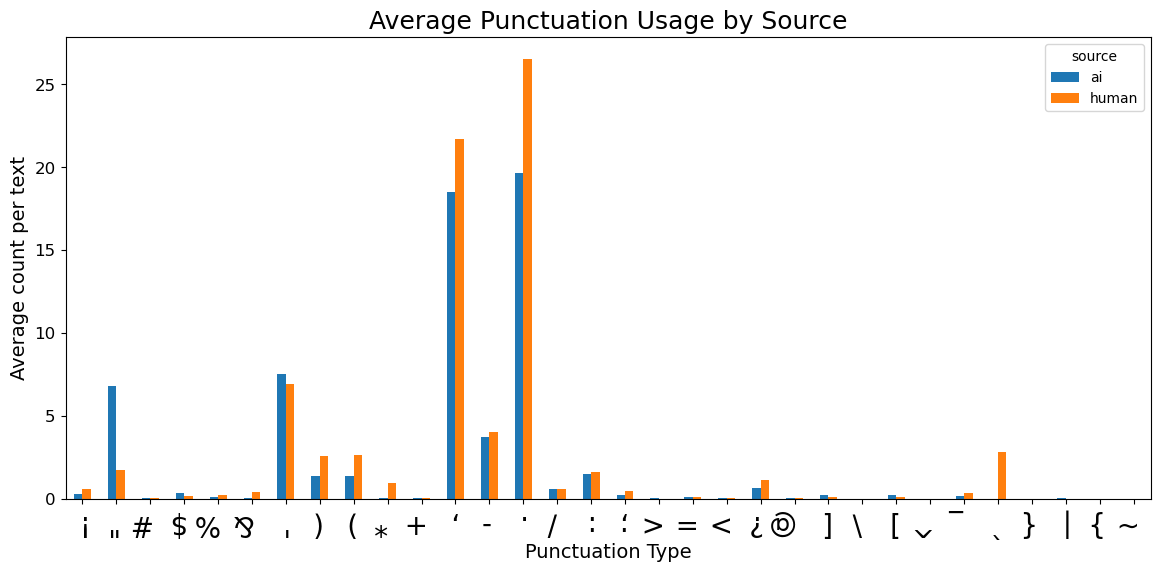

In [ ]:
punct_avg.index = punct_avg.index.str.replace("count_", "", regex=False)

# Plot
punct_avg.plot(kind="bar", figsize=(14,6))

plt.title("Average Punctuation Usage by Source", fontsize=18)   # Bigger title font
plt.ylabel("Average count per text", fontsize=14)               # Bigger y-axis label font
plt.xlabel("Punctuation Type", fontsize=14)                     # Bigger x-axis label font

plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)                                         # Bigger y-ticks

plt.show()

In [82]:
df["punct_total"] = df["text"].apply(lambda x: len(re.findall(rf"[{re.escape(string.punctuation)}]", str(x))))
avg_punct = df.groupby("source")["punct_total"].mean()
print(avg_punct)

source
ai       64.400750
human    76.660017
Name: punct_total, dtype: float64


In [83]:
df["unique_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_],count_^,count__,count_`,count_{,count_|,count_},count_~,punct_total,unique_ratio
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,121,0.466752
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,41,0.591195
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,14,0,0,0,0,77,0.728261
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,22,0.720497
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,6,0,0,0,0,36,0.718919


In [ ]:
avg_unique_ratio = df.groupby("source")["unique_ratio"].mean()
print(avg_unique_ratio)

source
ai       0.595630
human    0.650091
Name: unique_ratio, dtype: float64


<Axes: xlabel='source', ylabel='unique_ratio'>

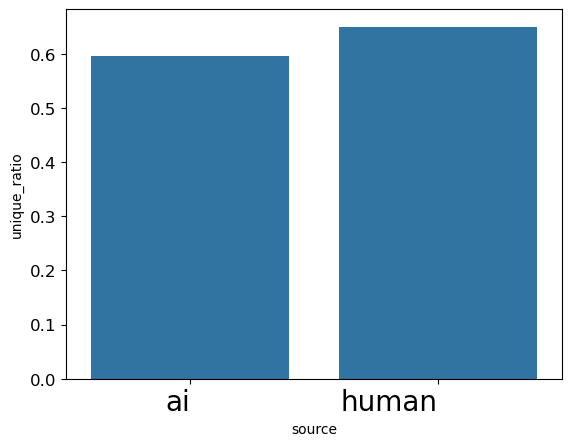

In [93]:
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
sns.barplot(data=avg_unique_ratio)

# data engineering 2

In [99]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_],count_^,count__,count_`,count_{,count_|,count_},count_~,punct_total,unique_ratio
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,121,0.466752
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,41,0.591195
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,14,0,0,0,0,77,0.728261
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,22,0.720497
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,6,0,0,0,0,36,0.718919


In [104]:
df_small = df.loc[df['text_length']<100]

In [107]:
len(df_small)

7119

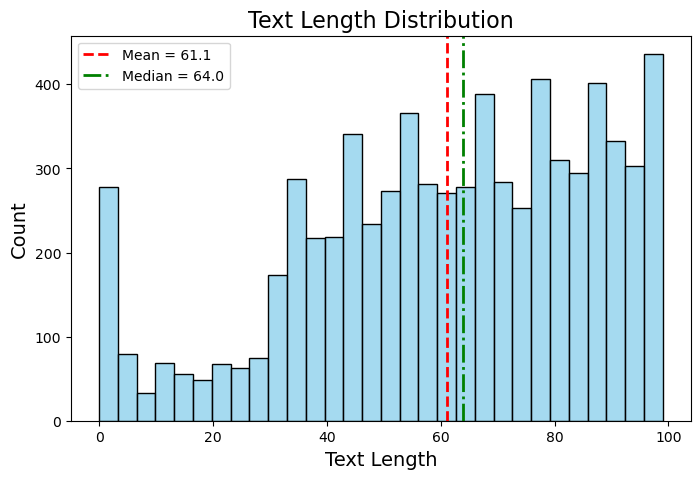

In [105]:
plt.figure(figsize=(8,5))

# Plot a single histogram (no separation by source)
sns.histplot(df_small["text_length"], bins=30, kde=False, color="skyblue")

# Calculate stats
mean_val = df_small["text_length"].mean()
median_val = df_small["text_length"].median()

# Add lines
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.1f}")

# Titles & labels
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

plt.show()